In [29]:
import pandas as pd
from qolmat.benchmark import comparator, missing_patterns
from qolmat.imputations import imputers
from sklearn.linear_model import LinearRegression

from qolmat.utils import plot

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
df = pd.read_csv("../data/train.csv")

In [8]:
df

,id,valeur_NO2,valeur_CO,valeur_O3,valeur_PM10,valeur_PM25
0,2020-01-01 00,42.9,0.718,15.7,73.1,64.4
1,2020-01-01 01,33.6,0.587,10.1,74.8,66.0
2,2020-01-01 02,29.3,NaN,5.1,51.0,44.9
3,2020-01-01 03,30.5,0.246,7.2,27.7,25.1
4,2020-01-01 04,29.3,0.204,8.3,15.3,13.6
...,...,...,...,...,...,...
40986,2024-09-03 18,NaN,0.222,55.1,12.0,5.3
40987,2024-09-03 19,NaN,0.245,48.2,13.4,7.0
40988,2024-09-03 20,NaN,0.234,44.5,12.4,7.1
40989,2024-09-03 21,NaN,0.225,25.9,10.6,5.4


In [19]:
df.set_index("id", inplace=True)

In [22]:
df.index = pd.to_datetime(df.index)

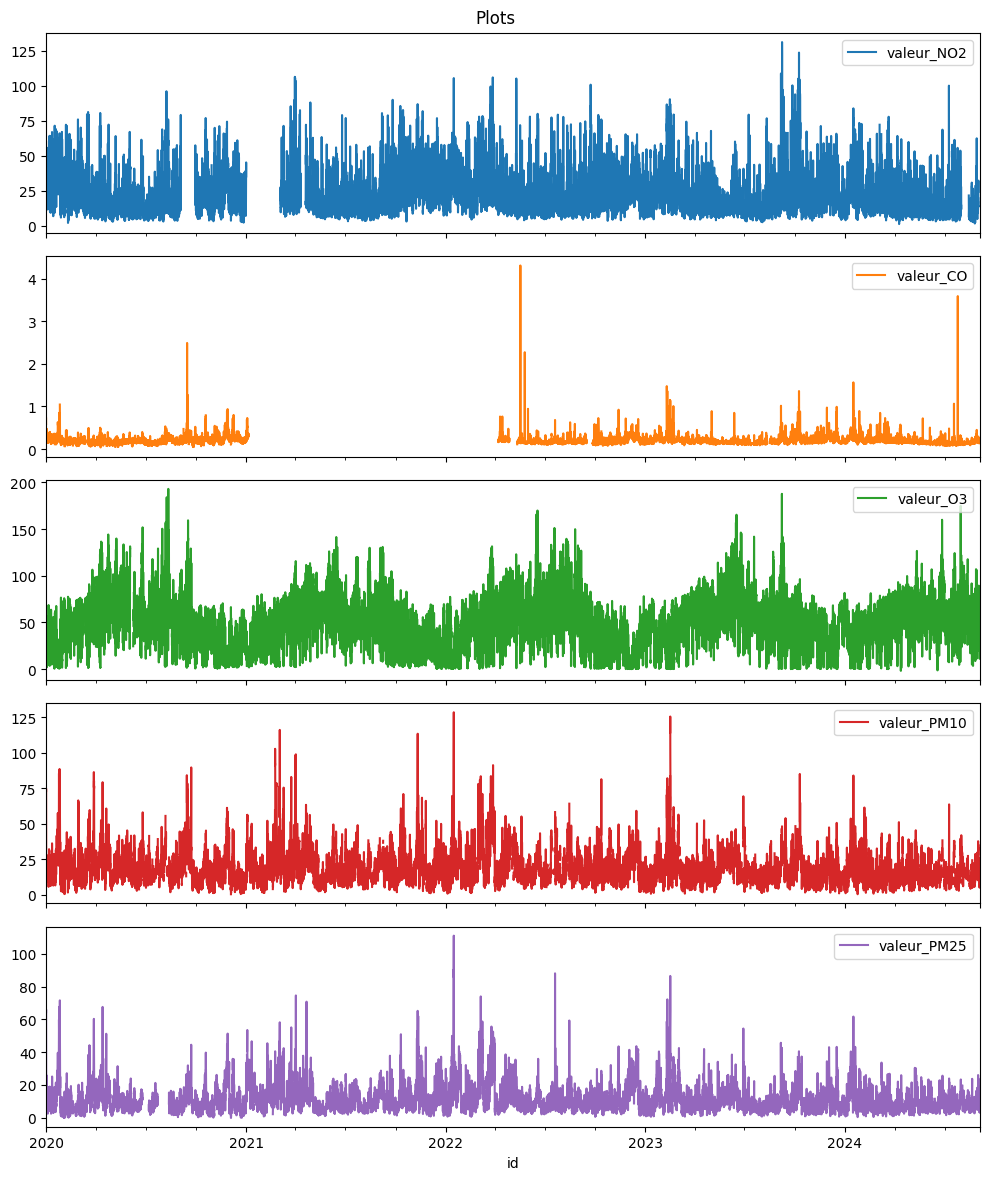

In [24]:
# Plotting the various columns in the dataframe
df.plot(subplots=True, figsize=(10, 12), title="Plots")
plt.tight_layout()
plt.show()

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40991 entries, 0 to 40990
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           40991 non-null  object 
 1   valeur_NO2   37694 non-null  float64
 2   valeur_CO    28462 non-null  float64
 3   valeur_O3    40298 non-null  float64
 4   valeur_PM10  33824 non-null  float64
 5   valeur_PM25  39200 non-null  float64
dtypes: float64(5), object(1)
memory usage: 1.9+ MB


In [12]:
columns = ["valeur_NO2", "valeur_CO", "valeur_O3", "valeur_PM10", "valeur_PM25"]


In [22]:
imputer_median = imputers.ImputerSimple(strategy="median")
imputer_mean = imputers.ImputerSimple(strategy="mean")
imputer_interpol = imputers.ImputerInterpolation(method="linear")
imputer_residuals = imputers.ImputerResiduals(
    period=365,
    model_tsa="additive",
    extrapolate_trend="freq",
    method_interpolation="linear",
)

In [23]:
imputer_tsou = imputers.ImputerEM(
    model="VAR",
    method="sample",
    max_iter_em=30,
    n_iter_ou=15,
    dt=1e-3,
    p=1,
)


In [24]:
imputer_mice = imputers.ImputerMICE(
    estimator=LinearRegression(),
    sample_posterior=False,
    max_iter=100,
)


In [25]:
imputer_mice = imputers.ImputerMICE(
    estimator=LinearRegression(),
    sample_posterior=False,
    max_iter=100,
)


In [35]:
dict_imputers = {
    "median": imputer_median,
    "interpolation": imputer_interpol,
    "residuals": imputer_residuals,
    # "TSOU": imputer_tsou,
    "mice": imputer_mice,
}


In [36]:
n_imputers = len(dict_imputers)
ratio_masked = 0.1

In [37]:
generator_holes = missing_patterns.EmpiricalHoleGenerator(
    n_splits=4, subset=columns, ratio_masked=ratio_masked
)


In [38]:
comparison = comparator.Comparator(
    dict_imputers,
    columns,
    generator_holes,
    metrics=["mae", "wmape", "KL_columnwise", "wasserstein_columnwise"],
    max_evals=10,
)


In [39]:
import warnings

warnings.filterwarnings("ignore")

In [40]:
results = comparison.compare(df)


Testing model: median...done.
Testing model: interpolation...done.
Testing model: residuals...done.
Testing model: mice...done.


In [41]:
results.style.highlight_min(color="lightsteelblue", axis=1)


1. For O3- Interpolation
2. For others - MICE

In [45]:
tab10 = plt.get_cmap("tab10")
import numpy as np
import matplotlib.ticker as plticker
import matplotlib.cm as cm


In [47]:
df.set_index("id", inplace=True)

df.index = pd.to_datetime(df.index)

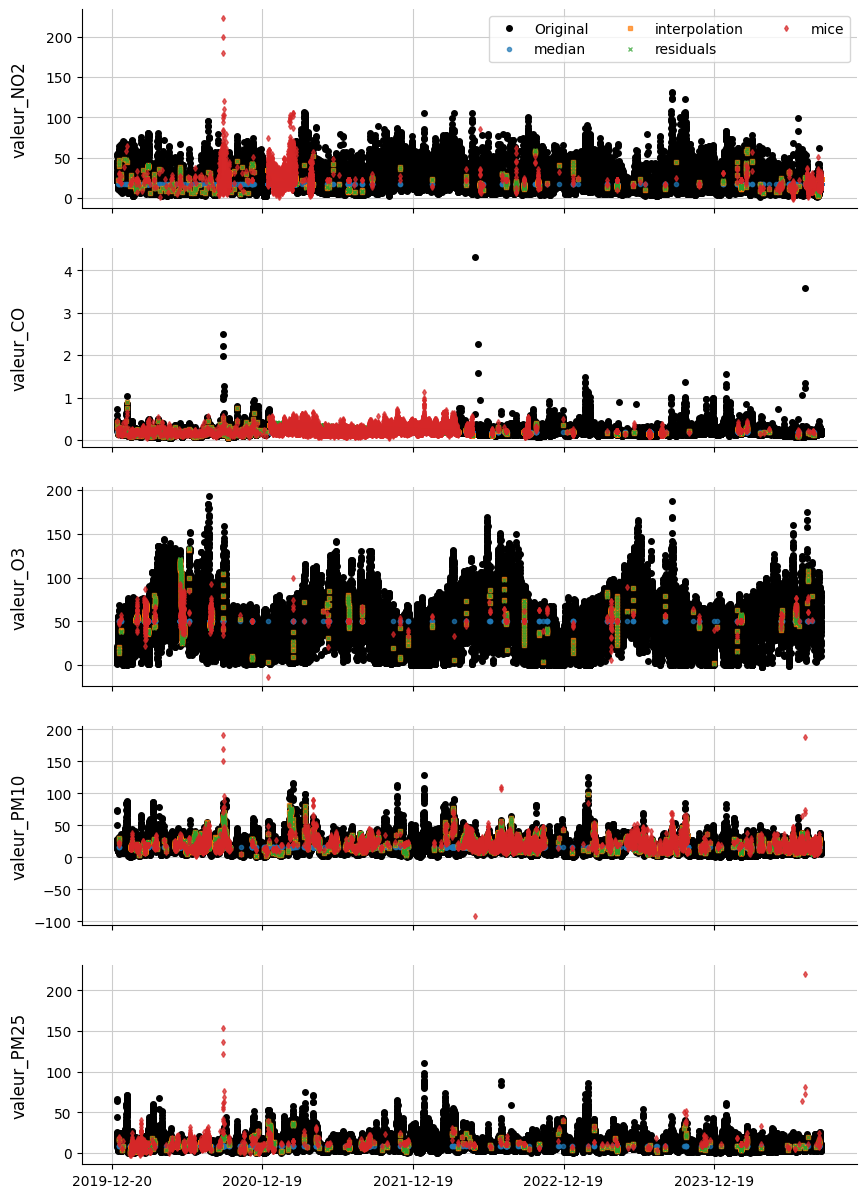

In [48]:
df_plot = df[columns]
dfs_imputed = {name: imp.fit_transform(df_plot) for name, imp in dict_imputers.items()}

# Creating a dictionary with imputed data, indexed by imputer names
dfs_imputed_station = {name: imputed_df for name, imputed_df in dfs_imputed.items()}

# Plotting setup
fig, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(10, 3 * len(columns)))
marker_styles = ["o", "s", "x", "d", "^"]  # Different markers for each imputer
for col, ax in zip(columns, axs.flatten()):
    values_orig = df_plot[col]
    ax.plot(
        values_orig, "o", color="black", label="Original", markersize=4
    )  # Larger markers for original data

    # Plot imputed values with different colors and marker styles
    for ind, (name, df_imp) in enumerate(dfs_imputed_station.items()):
        values_imp = df_imp[col].copy()
        values_imp[values_orig.notna()] = np.nan  # Keep original values visible
        color = cm.tab10(ind % 10)  # Use colormap to cycle colors
        marker = marker_styles[ind % len(marker_styles)]  # Cycle marker styles
        ax.plot(
            values_imp, marker, color=color, label=name, alpha=0.7, markersize=3
        )  # Smaller, semi-transparent markers

    ax.set_ylabel(col, fontsize=12)

# Add legend and format x-axis
axs[0].legend(fontsize=10, ncol=3)
for ax in axs:
    ax.tick_params(axis="both", which="major", labelsize=10)
loc = plticker.MultipleLocator(base=365)  # Yearly ticks
axs[-1].xaxis.set_major_locator(loc)
fig.align_labels()
plt.show()


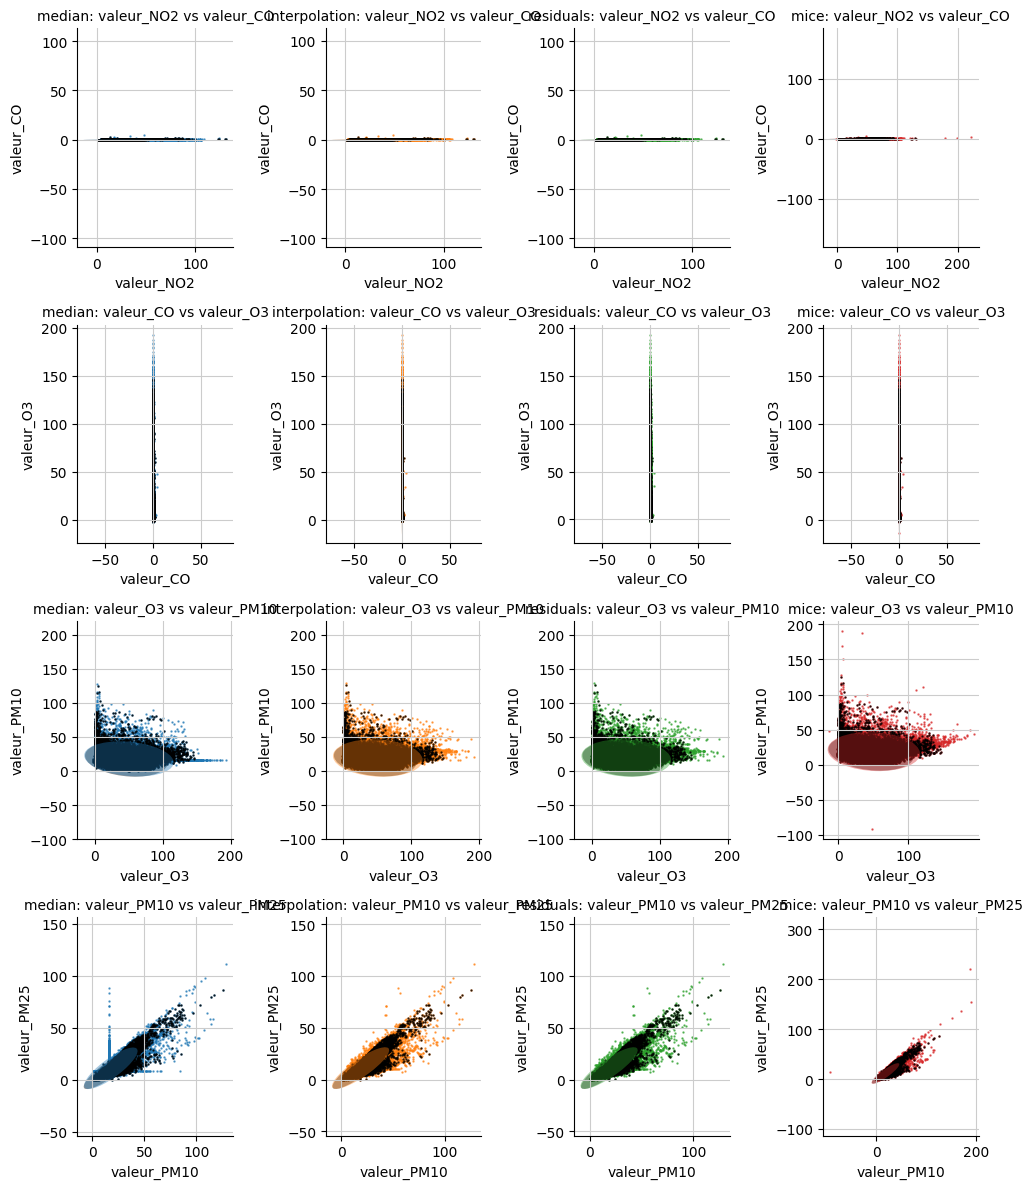

In [51]:
n_columns = len(columns) - 1  # Number of column pairs to compare
n_imputers = 4  # Number of imputers
fig = plt.figure(figsize=(10, 3 * n_columns))
i_plot = 1

for i, col in enumerate(columns[:-1]):
    for i_imputer, (name_imputer, df_imp) in enumerate(dfs_imputed_station.items()):
        ax = fig.add_subplot(n_columns, n_imputers, i_plot)

        # Pass the original dataframe (`df_plot`) and the imputed dataframe (`df_imp`)
        plot.compare_covariances(
            df_plot,  # Original data
            df_imp,  # Imputed data
            col,  # First column for covariance
            columns[i + 1],  # Next column in sequence
            ax,
            color=cm.tab10(i_imputer),
            label=name_imputer,
        )

        ax.set_title(f"{name_imputer}: {col} vs {columns[i + 1]}", fontsize=10)
        i_plot += 1

plt.tight_layout()
plt.show()
